In [2]:
import tensorflow.keras.backend as K 

from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Activation, Add,DepthwiseConv2D, BatchNormalization, Concatenate, Conv2D, Dense,Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Input, Lambda,LeakyReLU, MaxPooling2D, Multiply, Permute, Reshape, UpSampling2D 
import collections
import tensorflow as tf
from tensorflow.keras import regularizers
from  tensorflow.keras.initializers import *
from keras_flops import get_flops

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    except RuntimeError as e:
        print(e)

In [3]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_path = '/content/drive/MyDrive/Paper/KMC Dataset for grading/Training/'
val_path = '/content/drive/MyDrive/Paper/KMC Dataset for grading/Validation/'
test_path = '/content/drive/MyDrive/Paper/KMC Dataset for grading/Test/'
batch_size = 4
img_height = 224
img_width = 224
no_of_classes = 5
classes_name = [0,1,2,3,4]
input_shape = (img_height , img_width , 3)


random_seed = np.random.seed(1142)

datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    horizontal_flip = False,
    vertical_flip = False,
    #validation_split = 0.1,
    featurewise_std_normalization=True)

train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True,
    class_mode='categorical')

validation_generator = datagen.flow_from_directory(
    val_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True,
    class_mode='categorical')


print(train_generator.class_indices)

Found 3432 images belonging to 5 classes.
Found 503 images belonging to 5 classes.
{'grade0': 0, 'grade1': 1, 'grade2': 2, 'grade3': 3, 'grade4': 4}


In [4]:
def res_block(x,f): 
    w,h,c = x.shape[1],x.shape[2],x.shape[3]
    x41 = AveragePooling2D(pool_size = (w,h))(x)
    x41 = Conv2D(f, (1, 1), activation='sigmoid', padding='same')(x41)
    x4 = Multiply()([x,x41])
    return x4

In [6]:
def conv_layer(x,f):
    conv1 = tf.keras.layers.Conv2D(f, kernel_size=(3, 3), padding='same')(x)
    norm1 = tf.keras.layers.BatchNormalization()(conv1)
    relu1 = tf.keras.layers.Activation('relu')(norm1)
    return relu1

def block(x,y):
    _, width, height, channels = x.get_shape().as_list()
    group_ch = channels // 2
    x = Reshape([width, height, group_ch, 2])(x)
    x = Permute([1, 2, 4, 3])(x)
    x0 = x[:,:,:,0]
    x1 = x[:,:,:,1]
    
    _, width, height, channels = y.get_shape().as_list()
    group_ch = channels // 2
    y = Reshape([width, height, group_ch, 2])(y)
    y = Permute([1, 2, 4, 3])(y)
    y0 = y[:,:,:,0]
    y1 = y[:,:,:,1]
    
    xy0 = Concatenate()([x0,y1])
    xy1 = Concatenate()([y0,x1])
        
    xy2 = conv_layer(xy0, channels)
    xy3 = conv_layer(xy1, channels) 
    x_o = res_block(xy2, channels)
    y_o = res_block(xy3, channels)
    x_out = Add()([x_o,y_o]) 
    return x_out

In [9]:
def resnet_block(block_input, num_filters):
    conv1 = conv_layer(block_input,num_filters)
    conv2 = block(block_input,conv1)
    sum = Add()([conv2,block_input])
    relu2 = tf.keras.layers.Activation('relu')(sum)
    return relu2

def se_resnet14():

  input = tf.keras.layers.Input(shape=(224, 224, 3))
  conv1 = conv_layer(input,16)

  block1 = resnet_block(conv1, 16)
  block2 = resnet_block(block1, 16)
  pool1 = tf.keras.layers.MaxPooling2D((2, 2), (2,2))(block2)
  conv2 = conv_layer(pool1,32)
  block4 = resnet_block(conv2, 32)
  block5 = resnet_block(block4, 32)
  pool2 = tf.keras.layers.MaxPooling2D((2, 2), (2,2))(block5)
  conv3 = conv_layer(pool2,64)
  block7 = resnet_block(conv3, 64)
  block8 = resnet_block(block7, 64)
  global_pool = tf.keras.layers.GlobalAveragePooling2D()(block8)
  x = Dense(128, activation='relu')(global_pool)
  x = Dense(128, activation='relu')(x)
  output = tf.keras.layers.Dense(5, activation='softmax')(x)
  model = tf.keras.models.Model(inputs=input, outputs=output)
  return model

In [10]:
model = se_resnet14()
model.compile(optimizer = 'Adam' , loss = 'categorical_crossentropy' , metrics = ["acc"])
model.summary()
flops = get_flops(model,batch_size=1)
print(f"Flops:{flops/10**9:.03}G")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_acc' , mode='max' ,
                                                  factor = 0.5 , patience = 5 , verbose=1 , cooldown = 1,
                                                 min_delta = 0.0001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=40, verbose=1,
                                              mode = 'max', restore_best_weights = True)
check_path = 'E:/Grading_Files/comp/trials/pro_222.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(check_path, monitor = 'val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')


history = model.fit_generator(train_generator , validation_data = validation_generator ,
                                  steps_per_epoch= len(train_generator) ,
                                  validation_steps = len(validation_generator)
                                  ,epochs = 65,callbacks = [reduce_lr, early_stop, checkpoint] )

Epoch 1/65
858/858 [==============================] - 64s 69ms/step - loss: 1.2927 - acc: 0.4664 - val_loss: 19.0693 - val_acc: 0.3121

Epoch 00001: val_acc improved from -inf to 0.31213, saving model to E:/Grading_Files/comp/trials\pro_222.h5
Epoch 2/65
858/858 [==============================] - 60s 70ms/step - loss: 0.9310 - acc: 0.6097 - val_loss: 2.4321 - val_acc: 0.2903

Epoch 00002: val_acc did not improve from 0.31213
Epoch 3/65
858/858 [==============================] - 61s 71ms/step - loss: 0.7597 - acc: 0.7075 - val_loss: 1.2875 - val_acc: 0.5030

Epoch 00003: val_acc improved from 0.31213 to 0.50298, saving model to E:/Grading_Files/comp/trials\pro_222.h5
Epoch 4/65
858/858 [==============================] - 61s 71ms/step - loss: 0.6620 - acc: 0.7352 - val_loss: 3.5782 - val_acc: 0.2724

Epoch 00004: val_acc did not improve from 0.50298
Epoch 5/65
858/858 [==============================] - 61s 71ms/step - loss: 0.5932 - acc: 0.7488 - val_loss: 2.5765 - val_acc: 0.3638

Epoch

In [11]:
a=np.load('E:/Grading_Files/comp/trials/Weight/Proposed/Pro_91.69.npy',allow_pickle='TRUE').item()

In [12]:
model.load_weights('E:/Grading_Files/comp/trials/Weight/Proposed/Pro_92.49.h5')

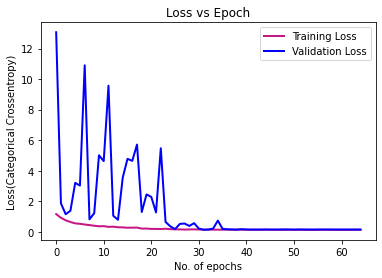

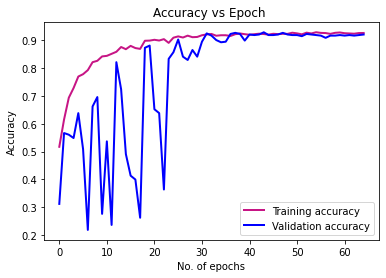

In [13]:
import matplotlib.pyplot as plt
plt.plot(a['loss'] , label = 'Training Loss',color='mediumvioletred', linewidth=2)
plt.plot(a['val_loss'] , label = 'Validation Loss',color='blue', linewidth=2)
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Loss(Categorical Crossentropy)")
plt.title("Loss vs Epoch")
# plt.savefig('/content/drive/MyDrive/Paper/Models/Proposed/plot/91.69-Loss.png',bbox_inches='tight')
plt.show()
plt.plot(a['acc'] , label = 'Training accuracy', color='mediumvioletred', linewidth=2)
plt.plot(a['val_acc'] , label = 'Validation accuracy', color='blue',linewidth=2)
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch ")
# plt.savefig('/content/drive/MyDrive/Paper/Models/Proposed/plot/91.69-ACC.png',bbox_inches='tight')
plt.show()

In [14]:
test_d = ImageDataGenerator(rescale=1. / 255)
test = test_d.flow_from_directory(
    '/content/drive/MyDrive/Paper/KMC Dataset for grading/Modified_Test/Test-22/',
    target_size=(224,224),
    batch_size=1,
    shuffle = False,
    class_mode='categorical')

Found 142 images belonging to 5 classes.


In [ ]:
import time
t0 = time.time()
pred = model.predict_generator(test)
t1 = time.time()
time_forloop = t1 - t0
print(time_forloop)

<ipython-input-12-c8062f8c0188>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(test)


44.56666803359985


In [15]:
import numpy as np
test_step = test.n//test.batch_size
test.reset()
pred = model.predict_generator(test , steps = test_step , verbose = 1)
pred_class_indices = np.argmax(pred,axis=1)

## printing predicted labels
print(pred_class_indices)

<ipython-input-15-973eef7dd801>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(test , steps = test_step , verbose = 1)


142/142 [==============================] - 52s 354ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 2 0 2 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 4 4 4 4 4 4]


In [17]:
from sklearn.metrics import *
classes = [0,1,2,3,4]


for cl in classes:

    print("class: ",cl)

    a1 = np.uint8(test.labels == cl)
    a2 = np.uint8(pred_class_indices == cl)

    print('Accuracy {}'.format(accuracy_score(y_true=a1, y_pred=a2)))
    print('F1 {}'.format(f1_score(y_true=a1, y_pred=a2)))
    print('precision {}'.format(precision_score(y_true=a1, y_pred=a2)))
    print('recall {}'.format(recall_score(y_true=a1, y_pred=a2)))

    print('jaccard {}'.format(jaccard_score(y_true=a1, y_pred=a2)))
    print("_______________________________")

class:  0
Accuracy 0.9859154929577465
F1 0.975609756097561
precision 0.975609756097561
recall 0.975609756097561
jaccard 0.9523809523809523
_______________________________
class:  1
Accuracy 0.9507042253521126
F1 0.8679245283018868
precision 0.8846153846153846
recall 0.8518518518518519
jaccard 0.7666666666666667
_______________________________
class:  2
Accuracy 0.9436619718309859
F1 0.8260869565217391
precision 0.9047619047619048
recall 0.76
jaccard 0.7037037037037037
_______________________________
class:  3
Accuracy 0.9436619718309859
F1 0.8400000000000001
precision 0.7241379310344828
recall 1.0
jaccard 0.7241379310344828
_______________________________
class:  4
Accuracy 0.9788732394366197
F1 0.9433962264150945
precision 1.0
recall 0.8928571428571429
jaccard 0.8928571428571429
_______________________________


In [18]:
print('Accuracy {}'.format(accuracy_score(y_true=test.labels, y_pred=pred_class_indices)))
print('F1 {}'.format(f1_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))
print('precision {}'.format(precision_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))
print('recall {}'.format(recall_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))

print('jaccard {}'.format(jaccard_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))
print('confusion_matrix\n {}'.format(confusion_matrix(y_true=test.labels, y_pred=pred_class_indices)))
print('classification_report\n {}'.format(classification_report(y_true=test.labels, y_pred=pred_class_indices)))
print('\n\n')

Accuracy 0.9014084507042254
F1 0.8906034934672563
precision 0.8978249953018664
recall 0.8960637501613112
jaccard 0.8079492793285897
confusion_matrix
 [[40  1  0  0  0]
 [ 1 23  2  1  0]
 [ 0  2 19  4  0]
 [ 0  0  0 21  0]
 [ 0  0  0  3 25]]
classification_report
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        41
           1       0.88      0.85      0.87        27
           2       0.90      0.76      0.83        25
           3       0.72      1.00      0.84        21
           4       1.00      0.89      0.94        28

    accuracy                           0.90       142
   macro avg       0.90      0.90      0.89       142
weighted avg       0.91      0.90      0.90       142






Confusion matrix, without normalization
[[40  1  0  0  0]
 [ 1 23  2  1  0]
 [ 0  2 19  4  0]
 [ 0  0  0 21  0]
 [ 0  0  0  3 25]]


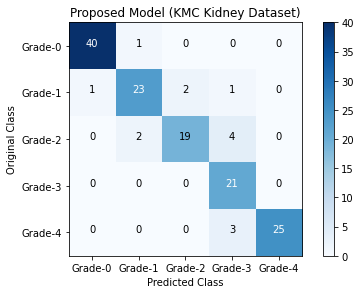

In [19]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true=test.labels, y_pred=pred_class_indices)
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
labels = [ "Grade-0","Grade-1","Grade-2","Grade-3","Grade-4"]  
plot_confusion_matrix(cm, labels,
                        normalize=False,
                        title='Proposed Model (KMC Kidney Dataset)',
                        cmap=plt.cm.Blues)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
# plt.title("Confusion matrix")
# plt.savefig('/content/drive/MyDrive/Paper/Models/Proposed/plot/Confusion-Matrix-Pro-92.48.png',bbox_inches='tight')
plt.show()

class:  0
class:  1
class:  2
class:  3
class:  4


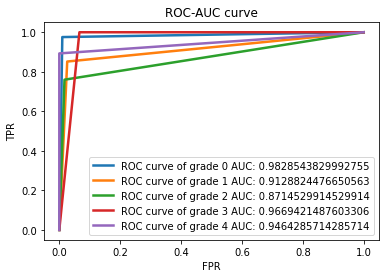

In [20]:
from sklearn.metrics import *

for cl in classes:

    print("class: ",cl)

    a1 = np.uint8(test.labels == cl)
    a2 = np.uint8(pred_class_indices == cl)

    fpr,tpr,_ = roc_curve(a1,a2)
    roc_auc = auc(fpr,tpr)

    plt.plot(fpr,tpr,label = "ROC curve of grade " + str(cl) + " AUC: " + str(roc_auc),linewidth=2.5)

plt.title("ROC-AUC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
# plt.savefig('/content/drive/MyDrive/Paper/Models/Proposed/plot/ROC-Pro-92.48.png',bbox_inches='tight')
plt.show()